# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes



config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': -1,
        'fully_grown': True,    
        'dt_type': 'SDT', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [0,1,2],
        
        'function_generation_type': 'random_decision_tree',# 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        #'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [4096, 2048, 1024, 512],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.2, 0.2, 0.2, 0],
        
        'optimizer': 'adam', #adam
        'learning_rate': 0.001,
        'loss': 'binary_crossentropy', #mse
        'metrics': ['mse', 'binary_accuracy'],
        
        'epochs': 200, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 10000,
                
        'test_size': 50, #Float for fraction, Int for number 0
        
        'function_representation_type': 2, # 1=standard representation; 2=sparse representation with classification for variables
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
        'soft_labels': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500, 
        'per_network_optimization_dataset_size': 5000,

        'sklearn_dt_benchmark': False,
        'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 100,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 100,
            
        }
        
    },    
    
    'computation':{
        'load_model': False,
        'n_jobs': 10,
        'use_gpu': True,
        'gpu_numbers': '1',
        'RANDOM_SEED': 42,   
    }
}


## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)


from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

from copy import deepcopy
import math
import random 


import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder

#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.5.2'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
config['function_family']['decision_sparsity'] = config['function_family']['decision_sparsity'] if config['function_family']['decision_sparsity'] != -1 else config['data']['number_of_variables'] 

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else None
                                                            )
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))

create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets10000_var10_class2_random_decision_tree_xMax1_xMin0_xDistuniform_depth3_beta1_decisionSpars-1_SDT_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense4096-2048-1024-512_drop0.2-0.2-0.2-0e200b256_adam
lNetSize5000_numLNets10000_var10_class2_random_decision_tree_xMax1_xMin0_xDistuniform_depth3_beta1_decisionSpars-1_SDT_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    #path_X_data = directory + 'X_test_lambda.txt'
    #path_y_data = directory + 'y_test_lambda.txt'        
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    if no_noise == False:
        network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
       
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              #X_test_lambda_row, 
                                              #y_test_lambda_row, 
                                              config) for network_parameters_row in network_parameters.values)          
    del parallel
    
    base_model = generate_base_model(config)  
    
    #def initialize_network_wrapper(config, lambda_net, base_model):
    #    lambda_net.initialize_network(config, base_model)
    
    #parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    #_ = parallel(delayed(initialize_network_wrapper)(config, lambda_net, base_model) for lambda_net in lambda_nets)   
    #del parallel
    
    #def initialize_target_function_wrapper(config, lambda_net):
    #    lambda_net.initialize_target_function(config)
    
    #parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    #_ = parallel(delayed(initialize_target_function_wrapper)(config, lambda_net) for lambda_net in lambda_nets)   
    #del parallel
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    

    lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
    lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

    lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)    
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done 244 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done 8212 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done 10000 out of 10000 | elapsed:    9.5s finished


## Data Inspection

In [12]:
lambda_net_dataset_train.shape

(8955, 1632)

In [13]:
lambda_net_dataset_valid.shape

(995, 1632)

In [14]:
lambda_net_dataset_test.shape

(50, 1632)

In [15]:
lambda_net_dataset_train.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,wb_0,wb_1,wb_2,wb_3,wb_4,...,wb_1437,wb_1438,wb_1439,wb_1440,wb_1441,wb_1442,wb_1443,wb_1444,wb_1445,wb_1446,wb_1447,wb_1448,wb_1449,wb_1450,wb_1451,wb_1452,wb_1453,wb_1454,wb_1455,wb_1456,wb_1457,wb_1458,wb_1459,wb_1460,wb_1461,wb_1462,wb_1463,wb_1464,wb_1465,wb_1466,wb_1467,wb_1468,wb_1469,wb_1470,wb_1471,wb_1472,wb_1473,wb_1474,wb_1475,wb_1476,wb_1477,wb_1478,wb_1479,wb_1480,wb_1481,wb_1482,wb_1483,wb_1484,wb_1485,wb_1486,wb_1487,wb_1488,wb_1489,wb_1490,wb_1491,wb_1492,wb_1493,wb_1494,wb_1495,wb_1496,wb_1497,wb_1498,wb_1499,wb_1500,wb_1501,wb_1502,wb_1503,wb_1504,wb_1505,wb_1506,wb_1507,wb_1508,wb_1509,wb_1510,wb_1511,wb_1512,wb_1513,wb_1514,wb_1515,wb_1516,wb_1517,wb_1518,wb_1519,wb_1520,wb_1521,wb_1522,wb_1523,wb_1524,wb_1525,wb_1526,wb_1527,wb_1528,wb_1529,wb_1530,wb_1531,wb_1532,wb_1533,wb_1534,wb_1535,wb_1536
6671,6671.000,42,0.010,0.115,-0.222,0.217,0.048,0.097,0.230,-0.260,0.246,0.075,-0.063,-0.265,-0.103,0.001,-0.188,0.273,-0.304,-0.006,-0.293,0.145,0.014,-0.253,0.103,-0.281,-0.050,-0.310,0.181,-0.277,-0.004,0.240,0.034,-0.013,0.084,-0.041,-0.197,-0.265,-0.226,0.118,-0.111,-0.221,-0.062,0.029,0.205,0.087,0.169,0.187,-0.232,0.041,-0.144,0.116,-0.190,0.121,-0.260,0.234,0.261,0.311,-0.040,-0.305,-0.201,-0.273,0.010,-0.116,-0.284,0.221,-0.242,0.146,0.282,0.221,-0.128,0.129,0.040,-0.010,-0.131,-0.163,-0.032,-0.285,0.016,0.349,0.167,0.042,0.023,0.096,0.128,-0.139,-0.169,-0.247,0.028,0.122,-0.272,0.320,-0.176,0.082,0.053,0.210,-0.114,-0.031,-0.110,-0.126,...,-1.348,-1.304,0.411,0.139,0.354,-2.005,0.438,0.407,0.451,0.301,-1.683,0.371,0.560,0.108,0.621,0.928,0.719,0.395,-1.306,0.390,-1.020,0.974,-0.949,-0.877,-0.113,0.338,0.358,0.292,-1.561,-0.999,0.084,-0.048,0.575,-0.098,0.565,0.295,-0.554,-0.739,1.032,-0.607,-1.353,-0.926,0.390,0.285,-1.114,0.345,-1.766,-1.401,0.887,0.345,-2.208,-0.544,-1.197,-1.252,0.373,-1.805,-1.784,-1.421,0.110,0.089,-1.065,0.377,-1.093,-1.075,0.284,0.362,-1.630,-0.587,0.321,0.230,-1.716,-0.603,-2.286,-1.043,-2.212,0.341,0.731,0.077,0.383,-1.211,-0.701,0.067,-0.425,-1.501,0.457,0.302,-2.138,-0.818,0.858,0.444,0.109,0.281,0.512,0.198,-0.797,-0.867,0.604,-1.320,0.316,-0.047
3274,3274.000,42,0.070,-0.092,-0.100,0.019,0.225,0.028,-0.242,-0.075,-0.032,-0.162,0.081,-0.155,-0.266,0.205,0.129,-0.090,-0.268,-0.147,0.203,0.152,-0.056,-0.044,0.221,-0.222,0.144,-0.279,0.243,0.051,0.073,-0.141,-0.254,-0.117,0.303,-0.014,0.304,-0.289,0.141,0.158,-0.224,-0.256,0.202,0.088,0.224,-0.251,0.012,-0.130,0.043,0.136,0.186,0.010,0.111,0.050,0.070,0.127,-0.121,-0.211,0.249,0.279,0.304,-0.292,-0.007,0.280,0.079,-0.026,-0.288,-0.168,0.145,0.253,0.180,-0.109,0.046,-0.049,-0.253,-0.090,-0.038,0.254,-0.232,0.064,-0.189,0.138,-0.004,-0.280,-0.336,-0.154,-0.232,-0.018,0.001,-0.345,0.279,0.119,-0.326,0.040,0.019,-0.108,0.255,-0.068,0.006,-0.034,...,-0.977,-0.757,0.677,0.155,0.313,-2.083,0.054,-0.634,0.430,0.571,-0.651,-0.442,0.038,1.399,0.099,0.133,0.101,0.614,-1.510,0.068,-1.611,0.091,-1.508,-1.204,-0.113,-0.431,0.094,0.436,-0.096,-1.588,0.767,-1.429,1.071,-1.513,0.179,0.531,-1.894,-1.067,-0.675,-1.495,-0.845,-0.552,1.278,-0.692,-0.520,-1.037,-0.630,-0.444,-1.379,0.567,-0.915,-0.653,-0.630,-0.872,0.068,-1.237,-0.167,-0.867,0.572,-0.300,-0.538,0.395,-1.155,-0.892,0.312,0.611,-0.472,-0.441,0.415,0.236,-0.751,-1.498,-1.791,-0.485,-1.568,0.507,0.618,0.099,0.592,-0.956,-1.456,0.067,-1.700,-0.567,0.562,-0.322,-1.582,-1.325,1.041,0.059,0.177,0.387,0.112,0.158,0.561,-0.631,0.306,-1.244,-0.417,0.001
3095,3095.000,42,0.124,-0.054,-0.095,-0.157,0.231,0.025,0.209,-0.033,0.1

In [16]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,wb_0,wb_1,wb_2,wb_3,wb_4,...,wb_1437,wb_1438,wb_1439,wb_1440,wb_1441,wb_1442,wb_1443,wb_1444,wb_1445,wb_1446,wb_1447,wb_1448,wb_1449,wb_1450,wb_1451,wb_1452,wb_1453,wb_1454,wb_1455,wb_1456,wb_1457,wb_1458,wb_1459,wb_1460,wb_1461,wb_1462,wb_1463,wb_1464,wb_1465,wb_1466,wb_1467,wb_1468,wb_1469,wb_1470,wb_1471,wb_1472,wb_1473,wb_1474,wb_1475,wb_1476,wb_1477,wb_1478,wb_1479,wb_1480,wb_1481,wb_1482,wb_1483,wb_1484,wb_1485,wb_1486,wb_1487,wb_1488,wb_1489,wb_1490,wb_1491,wb_1492,wb_1493,wb_1494,wb_1495,wb_1496,wb_1497,wb_1498,wb_1499,wb_1500,wb_1501,wb_1502,wb_1503,wb_1504,wb_1505,wb_1506,wb_1507,wb_1508,wb_1509,wb_1510,wb_1511,wb_1512,wb_1513,wb_1514,wb_1515,wb_1516,wb_1517,wb_1518,wb_1519,wb_1520,wb_1521,wb_1522,wb_1523,wb_1524,wb_1525,wb_1526,wb_1527,wb_1528,wb_1529,wb_1530,wb_1531,wb_1532,wb_1533,wb_1534,wb_1535,wb_1536
3466,3466.000,42,-0.090,-0.215,0.115,-0.049,-0.202,-0.022,0.061,-0.208,-0.014,-0.275,-0.004,0.126,-0.028,0.006,0.211,0.219,-0.141,-0.229,-0.280,0.311,0.229,-0.087,-0.034,0.127,-0.285,0.218,0.200,0.146,-0.017,-0.062,0.223,0.310,-0.230,0.086,0.293,-0.208,0.029,-0.098,0.232,0.022,-0.067,0.017,-0.222,0.187,0.115,-0.313,0.273,0.303,0.151,0.315,0.117,0.304,-0.273,-0.159,0.226,-0.190,0.238,-0.282,0.010,0.235,0.184,-0.242,-0.290,-0.244,0.086,-0.090,-0.069,0.080,-0.230,0.271,-0.113,0.303,0.094,0.199,0.253,0.061,-0.279,-0.064,-0.035,-0.185,0.229,0.078,0.160,-0.080,0.245,-0.015,0.330,0.346,0.205,0.088,0.255,0.297,0.172,-0.161,0.261,0.248,-0.267,-0.257,...,0.495,-1.564,0.561,0.559,0.209,-0.527,0.892,0.414,0.585,-1.368,-0.843,0.408,0.503,0.392,0.559,0.597,0.578,0.557,-0.661,0.193,-1.893,0.552,-0.126,-0.131,-0.113,-0.411,0.558,0.209,-1.394,-1.548,0.547,-1.693,0.528,-0.558,0.909,0.336,-1.629,0.484,0.442,-0.405,-0.083,-1.433,0.700,0.753,-0.584,-0.460,-0.484,-1.362,-1.418,0.871,-1.728,-1.310,-0.791,-0.534,0.519,0.526,-1.538,-0.785,0.492,-0.372,-0.972,0.352,-0.511,-1.314,0.238,0.738,0.540,-0.270,0.549,0.406,-1.480,-0.580,-0.174,-0.886,-0.092,0.410,0.455,0.635,0.832,-1.209,-0.918,0.067,-0.339,0.545,0.528,0.323,-0.685,-0.711,0.695,0.589,0.703,0.165,0.541,-0.305,-1.213,-1.563,0.523,0.639,-0.383,0.012
689,689.000,42,0.069,-0.297,0.278,-0.261,0.150,0.263,-0.064,0.006,0.269,-0.062,-0.218,-0.145,0.280,-0.036,0.267,0.030,0.275,-0.181,0.046,0.230,0.160,-0.158,0.207,-0.019,-0.074,-0.090,-0.114,0.268,0.139,0.084,0.016,-0.115,-0.217,0.239,-0.193,0.010,-0.138,-0.075,0.052,0.017,0.055,-0.247,0.027,0.021,-0.178,0.180,-0.078,0.189,-0.060,-0.184,-0.235,-0.269,-0.302,-0.304,-0.249,-0.168,-0.273,0.036,-0.216,0.090,0.185,-0.217,-0.040,-0.092,-0.158,-0.013,0.111,-0.170,0.042,0.195,0.140,0.150,-0.176,0.215,-0.084,0.107,0.104,-0.223,0.321,0.202,-0.198,0.026,-0.284,-0.042,-0.140,-0.161,-0.266,-0.109,-0.326,-0.256,-0.266,-0.150,0.315,0.344,0.477,-0.165,-0.349,-0.263,...,0.881,-0.583,0.977,1.317,0.845,-2.041,1.261,1.596,0.160,0.772,-0.158,0.574,1.204,0.729,0.907,1.762,0.854,1.089,-1.997,0.879,-0.172,0.086,-0.117,-0.126,-0.113,-0.332,0.973,-0.288,-2.039,-0.638,1.021,-0.051,0.542,-1.533,1.185,-0.318,-0.100,0.749,0.765,-0.254,-0.087,-0.369,1.992,0.901,-0.476,-0.925,-0.427,-0.442,0.792,0.141,-0.128,-1.590,-0.458,-0.936,0.535,-1.277,-0.398,-0.945,0.106,-0.360,0.378,0.585,-1.756,-0.417,-0.491,1.965,0.839,-0.500,0.336,0.244,-0.368,-1.709,-0.182,-0.485,-0.086,-0.045,0.902,0.078,0.625,-1.774,-1.758,0.067,-0.408,1.012,0.862,-0.324,-0.164,-1.287,0.448,0.910,1.233,-0.341,0.899,-0.358,-0.777,-0.071,0.887,0.369,-0.345,0.207
4148,4148.000,42,0.140,-0.053,0.036,-0.267,-0.228,0.255,0.027,-0.286,-0.208,0.

In [17]:
lambda_net_dataset_test.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,wb_0,wb_1,wb_2,wb_3,wb_4,...,wb_1437,wb_1438,wb_1439,wb_1440,wb_1441,wb_1442,wb_1443,wb_1444,wb_1445,wb_1446,wb_1447,wb_1448,wb_1449,wb_1450,wb_1451,wb_1452,wb_1453,wb_1454,wb_1455,wb_1456,wb_1457,wb_1458,wb_1459,wb_1460,wb_1461,wb_1462,wb_1463,wb_1464,wb_1465,wb_1466,wb_1467,wb_1468,wb_1469,wb_1470,wb_1471,wb_1472,wb_1473,wb_1474,wb_1475,wb_1476,wb_1477,wb_1478,wb_1479,wb_1480,wb_1481,wb_1482,wb_1483,wb_1484,wb_1485,wb_1486,wb_1487,wb_1488,wb_1489,wb_1490,wb_1491,wb_1492,wb_1493,wb_1494,wb_1495,wb_1496,wb_1497,wb_1498,wb_1499,wb_1500,wb_1501,wb_1502,wb_1503,wb_1504,wb_1505,wb_1506,wb_1507,wb_1508,wb_1509,wb_1510,wb_1511,wb_1512,wb_1513,wb_1514,wb_1515,wb_1516,wb_1517,wb_1518,wb_1519,wb_1520,wb_1521,wb_1522,wb_1523,wb_1524,wb_1525,wb_1526,wb_1527,wb_1528,wb_1529,wb_1530,wb_1531,wb_1532,wb_1533,wb_1534,wb_1535,wb_1536
7217,7217.000,42,0.290,0.156,-0.196,0.066,-0.153,-0.304,0.150,0.020,0.089,-0.285,0.140,-0.019,0.119,0.309,0.035,-0.185,0.078,-0.134,-0.093,-0.239,-0.146,0.140,-0.288,0.310,0.220,0.266,0.275,0.314,0.203,0.055,-0.115,0.048,0.215,0.042,-0.026,0.266,0.196,0.206,-0.041,0.172,0.205,0.029,0.056,0.020,0.137,0.153,-0.300,0.199,-0.034,-0.151,0.284,0.201,-0.288,-0.313,-0.088,0.052,0.141,-0.040,-0.105,0.246,0.250,-0.277,-0.209,-0.222,0.177,0.045,-0.294,0.085,-0.266,-0.285,-0.142,-0.287,-0.154,-0.048,-0.298,-0.067,-0.307,-0.318,-0.184,-0.254,0.072,-0.287,0.236,0.166,-0.346,0.045,0.202,0.146,-0.047,0.067,0.228,0.280,0.308,-0.130,0.045,0.072,-0.479,-0.520,...,-2.664,-0.080,0.543,0.846,0.331,-1.032,2.814,1.223,0.466,0.848,-1.194,0.598,0.896,0.416,1.221,1.096,1.502,0.232,-1.160,2.673,-1.293,0.561,-0.124,-0.416,-0.113,-1.034,1.011,0.230,-0.689,-1.373,0.195,-2.951,1.211,-1.001,0.526,0.236,-0.101,1.020,0.866,-0.367,-0.090,-1.074,2.166,0.312,-1.227,-0.907,-1.095,1.928,-0.360,0.539,-2.441,-0.199,-1.208,-0.258,1.142,0.449,-2.131,-1.336,0.412,-0.592,-1.105,0.519,-0.915,-1.207,0.236,2.689,0.050,-0.124,0.893,0.962,-0.302,-1.183,-0.561,-0.686,-0.086,0.315,1.130,0.869,2.822,-0.836,-0.382,0.067,-0.212,1.195,0.300,-0.177,-2.707,-0.849,1.169,1.162,0.344,0.284,0.414,-0.088,-0.962,-1.604,0.799,0.905,-0.155,0.031
8291,8291.000,42,0.039,0.155,-0.213,-0.005,0.130,0.206,-0.188,0.190,-0.162,0.110,0.313,0.155,-0.157,-0.289,-0.229,0.266,0.159,-0.135,0.004,-0.031,-0.219,-0.043,0.082,0.306,-0.199,0.071,0.165,-0.125,0.300,-0.258,-0.125,0.183,0.137,-0.135,-0.069,-0.094,-0.276,-0.222,0.037,-0.239,0.028,0.272,-0.067,0.030,0.230,-0.146,0.074,-0.261,0.144,0.244,0.244,-0.202,0.017,-0.160,-0.056,0.170,-0.166,-0.202,-0.182,0.256,-0.048,0.068,-0.197,0.270,-0.070,-0.096,0.100,-0.308,-0.038,0.244,0.011,-0.121,-0.139,0.205,-0.235,0.047,-0.139,-0.181,-0.231,-0.018,0.064,-0.328,-0.001,-0.193,-0.333,0.036,0.007,-0.118,-0.112,-0.170,-0.343,0.157,-0.237,0.397,-0.447,-0.279,-0.139,-0.020,...,0.423,-1.797,0.599,2.094,0.200,-0.658,0.049,0.373,0.406,0.012,-1.834,0.406,1.980,1.942,0.457,1.591,1.731,0.353,-0.874,0.327,-1.339,1.083,-1.346,-0.743,-0.113,-0.427,1.229,0.587,-0.541,-1.762,3.115,-1.407,1.868,-0.602,1.056,0.415,-1.008,0.325,0.903,-0.718,-1.856,-0.518,1.379,0.689,-0.534,-0.444,-0.681,-2.213,-0.761,0.426,-0.126,-1.158,-0.684,-2.875,1.912,0.323,-1.739,-1.343,0.333,-0.426,-0.751,0.272,-0.863,-1.082,0.253,1.436,0.361,-1.349,0.383,0.327,-0.904,-0.582,-1.495,-0.565,-0.093,0.281,1.552,1.274,0.057,-0.155,-1.151,0.067,-1.041,0.361,2.332,0.595,-1.611,-0.935,2.019,2.166,2.244,0.327,1.042,-0.557,-0.486,-1.759,1.933,-0.450,1.074,-0.191
4607,4607.000,42,0.029,0.022,-0.138,-0.058,0.224,-0.076,0.235,-0.202,-0.256,-0

## Interpretation Network Training

In [18]:
#%load_ext autoreload

In [19]:
tf.where([True, True, False, True])

<tf.Tensor: shape=(3, 1), dtype=int64, numpy=
array([[0],
       [1],
       [3]])>

In [20]:
indices_node = tf.constant([0, 2, 3, 2])
indices_node

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 2, 3, 2], dtype=int32)>

In [21]:
values_node = tf.constant([1, 1, 1, 1])
values_node

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 1, 1, 1], dtype=int32)>

In [22]:
tf.unique(indices_node)

Unique(y=<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 2, 3], dtype=int32)>, idx=<tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 1, 2, 1], dtype=int32)>)

In [23]:
dense_tensor = []
for i in range(4):
    index_identifier = []
    for j, variable_index in enumerate(tf.unstack(indices_node)):
        if tf.equal(variable_index, i):
            index_identifier.append(j)
    index_identifier = tf.cast(tf.expand_dims(tf.stack(index_identifier), axis=1), tf.int64)
    #print(index_identifier)
    tf.print(tf.gather_nd(values_node, index_identifier))
    values_by_index = tf.reduce_sum(tf.gather_nd(values_node, index_identifier))
    tf.print('values_by_index', values_by_index)
    dense_tensor.append(values_by_index)
dense_tensor

[1]
values_by_index 1
[]
values_by_index 0
[1 1]
values_by_index 2
[1]
values_by_index 1


[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>]

In [24]:
dense_tensor = []
for i in range(4):
    index_identifier = tf.where(tf.equal(indices_node, i))
    tf.print(tf.gather_nd(values_node, index_identifier))
    values_by_index = tf.reduce_sum(tf.gather_nd(values_node, index_identifier))
    tf.print('values_by_index', values_by_index)
    dense_tensor.append(values_by_index)
dense_tensor

[1]
values_by_index 1
[]
values_by_index 0
[1 1]
values_by_index 2
[1]
values_by_index 1


[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>]

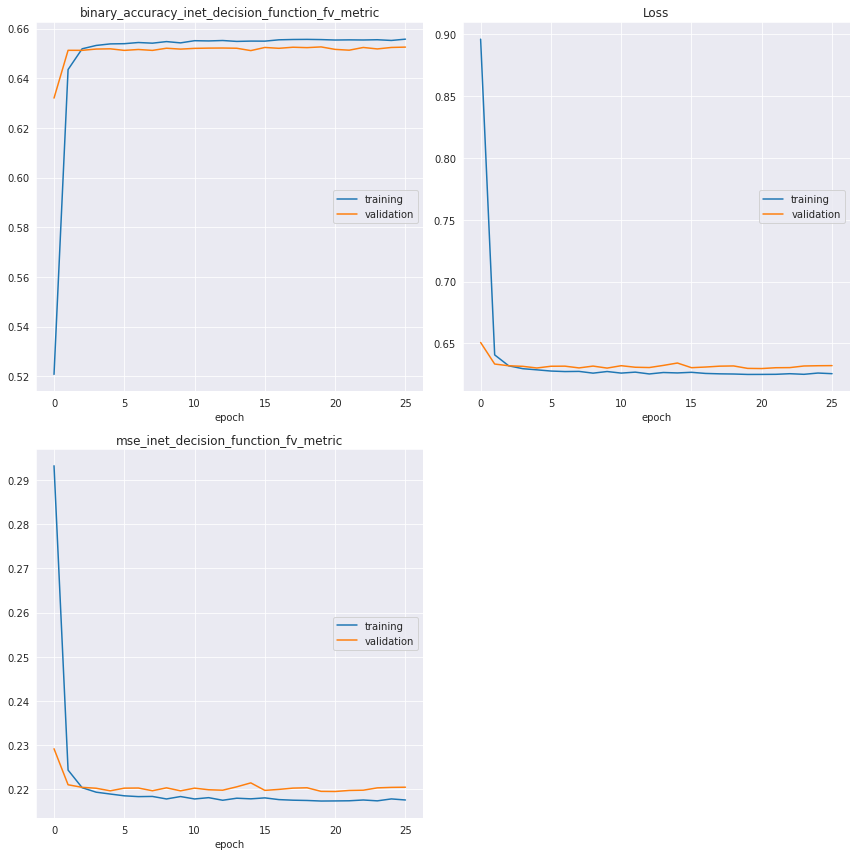

binary_accuracy_inet_decision_function_fv_metric
	training         	 (min:    0.521, max:    0.656, cur:    0.656)
	validation       	 (min:    0.632, max:    0.653, cur:    0.653)
Loss
	training         	 (min:    0.625, max:    0.896, cur:    0.625)
	validation       	 (min:    0.630, max:    0.651, cur:    0.632)
mse_inet_decision_function_fv_metric
	training         	 (min:    0.217, max:    0.293, cur:    0.218)
	validation       	 (min:    0.220, max:    0.229, cur:    0.221)
Epoch 27/200
 4/35 [==>...........................] - ETA: 23s - loss: 0.6225 - mse_inet_decision_function_fv_metric: 0.2163 - binary_accuracy_inet_decision_function_fv_metric: 0.6583

In [ ]:
#%autoreload 2
((X_valid, y_valid), 
 (X_test, y_test),
 
 history,
 loss_function,
 metrics,
 
 model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      callback_names=['plot_losses']
                                     )



In [ ]:
if nas:
    for trial in history: 
        print(trial.summary())
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

In [ ]:
index = 3
network_parameters = np.array([lambda_net_dataset_test.network_parameters_array[index]])
if (config['i_net']['convolution_layers'] != None or config['i_net']['lstm_layers'] != None or (config['i_net']['nas'] and config['i_net']['nas_type'] != 'SEQUENTIAL')) and config['i_net']['data_reshape_version'] is not None:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
dt_parameters = model.predict(network_parameters)[0]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

In [ ]:
model.summary()

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2
number = lambda_net_dataset_test.X_test_lambda_array.shape[0]#10

dt_inet_list = model.predict(lambda_net_dataset_test.network_parameters_array[:number])

dt_inet_list = []
runtime_list = []
for network in lambda_net_dataset_test.network_parameters_array[:number]:

    start_inet = time.time() 

    dt_inet = model.predict(np.array([network]))[0]
    
    end_inet = time.time()     
    inet_runtime = (end_inet - start_inet)   
    
    dt_inet_list.append(dt_inet)
    runtime_list.append(inet_runtime)    
    
dt_inet_list = np.array(dt_inet_list)
runtime_list = np.array(runtime_list)


parallel_inet_evaluation = Parallel(n_jobs=n_jobs, verbose=1, backend='loky') #loky #sequential multiprocessing

inet_evaluation_results_with_dt = parallel_inet_evaluation(delayed(evaluate_interpretation_net_prediction_single_sample)(lambda_net_parameters, 
                                                                                                               dt_inet,
                                                                                                               X_test_lambda, 
                                                                                                               #y_test_lambda,
                                                                                                               config) for lambda_net_parameters, 
                                                                                                                           dt_inet, 
                                                                                                                           X_test_lambda in zip(lambda_net_dataset_test.network_parameters_array[:number], 
                                                                                                                                                dt_inet_list, 
                                                                                                                                                lambda_net_dataset_test.X_test_lambda_array[:number]))      

del parallel_inet_evaluation

inet_evaluation_results = [entry[0] for entry in inet_evaluation_results_with_dt]
dt_distilled_list = [entry[1] for entry in inet_evaluation_results_with_dt]


inet_evaluation_result_dict = None
for some_dict in inet_evaluation_results:
    if inet_evaluation_result_dict == None:
        inet_evaluation_result_dict = some_dict
    else:
        inet_evaluation_result_dict = mergeDict(inet_evaluation_result_dict, some_dict)

inet_evaluation_result_dict['inet_scores']['runtime'] = runtime_list
        
        
inet_evaluation_result_dict_mean = {}

for key_l1, values_l1 in inet_evaluation_result_dict.items():
    if key_l1 != 'function_values':
        if isinstance(values_l1, dict):
            inet_evaluation_result_dict_mean[key_l1] = {}
            for key_l2, values_l2 in values_l1.items():
                inet_evaluation_result_dict_mean[key_l1][key_l2] = np.mean(values_l2)

                
inet_evaluation_result_dict_mean  
 

In [ ]:
print('Binary Crossentropy:\t', np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy'], 3), '(Sklearn DT)' , '\t', np.round(inet_evaluation_result_dict_mean['inet_scores']['binary_crossentropy'], 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy'], 3), '(Sklearn DT)' , '\t', np.round(inet_evaluation_result_dict_mean['inet_scores']['accuracy'], 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score'], 3), '(Sklearn DT)' , '\t', np.round(inet_evaluation_result_dict_mean['inet_scores']['f1_score'], 3), '(I-Net DT)')

print('Runtime:\t\t', np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime'], 3), '(Sklearn DT)' , '\t', np.round(inet_evaluation_result_dict_mean['inet_scores']['runtime'], 3), '(I-Net DT)')


In [ ]:
writepath_complete = './results_complete.csv'
writepath_summary = './results_summary.csv'

#TODO: ADD COMPLEXITY FOR DTS

if not os.path.exists(writepath_complete):
    with open(writepath_complete, 'w+') as text_file: 
        if different_eval_data:
            flat_config = flatten_dict(config_train)
        else:
            flat_config = flatten_dict(config)
            
        for key in flat_config.keys():
            text_file.write(key)
            text_file.write(';')
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('dt_scores_binary_crossentropy_' + str(i))
            text_file.write(';')
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('dt_scores_accuracy' + str(i))
            text_file.write(';')
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('dt_f1_score' + str(i))
            text_file.write(';')                
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('dt_scores_runtime_' + str(i))
            text_file.write(';')                
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('inet_binary_crossentropy_' + str(i))
            text_file.write(';')
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('inet_accuracy' + str(i))
            text_file.write(';')
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('inet_score' + str(i))
            text_file.write(';')                
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('inet_runtime_' + str(i))
            text_file.write(';')      
        text_file.write('\n')
    
with open(writepath_complete, 'a+') as text_file: 
    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    
    
    for value in flat_config.values():
        text_file.write(str(value))
        text_file.write(';')
    for value in inet_evaluation_result_dict['dt_scores']['binary_crossentropy']:
        text_file.write(str(value))
        text_file.write(';')
    for value in inet_evaluation_result_dict['dt_scores']['accuracy']:
        text_file.write(str(value))
        text_file.write(';')        
    for value in inet_evaluation_result_dict['dt_scores']['f1_score']:
        text_file.write(str(value))
        text_file.write(';')        
    for value in inet_evaluation_result_dict['dt_scores']['runtime']:
        text_file.write(str(value))
        text_file.write(';')
    for value in inet_evaluation_result_dict['inet_scores']['binary_crossentropy']:
        text_file.write(str(value))
        text_file.write(';')        
    for value in inet_evaluation_result_dict['inet_scores']['accuracy']:
        text_file.write(str(value))
        text_file.write(';')
    for value in inet_evaluation_result_dict['inet_scores']['f1_score']:
        text_file.write(str(value))
        text_file.write(';')        
    for value in inet_evaluation_result_dict['inet_scores']['runtime']:
        text_file.write(str(value))
        text_file.write(';')
    text_file.write('\n')

    text_file.close()  
    


# REAL DATA EVALUATION

## ADULT DATASET

In [ ]:
feature_names = [
                 "Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 "Sex",  #9
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                 "capital_gain" #14
                ] 



adult_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=feature_names, index_col=False)

adult_data.head()

In [ ]:
adult_data.describe()

In [ ]:
adult_data.info()

In [ ]:
adult_data['Workclass'][adult_data['Workclass'] != ' Private'] = 'Other'
adult_data['Race'][adult_data['Race'] != ' White'] = 'Other'

adult_data.head()

In [ ]:
features_select = [
                 "Sex",  #9 
                 "Race",  #8
                 "Workclass",  #1
                 "Age", #0
                 "fnlwgt",  #2
                 #"Education",  #3
                 "Education-Num",  #4
                 #"Marital Status", #5
                 #"Occupation",  #6
                 #"Relationship",  #7
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 #"Country", #13 
                 'capital_gain'
                  ]

adult_data = adult_data[features_select]

categorical_features = []#[1, 2, 7]
ordinal_features = ['Sex', 'Race', 'Workclass', 'capital_gain']

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(adult_data)

adult_data = transformer.transform(adult_data)
adult_data = pd.DataFrame(adult_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    adult_data[ordinal_feature] = OrdinalEncoder().fit_transform(adult_data[ordinal_feature].values.reshape(-1, 1)).flatten()

adult_data = adult_data.astype(np.float64)

    
X_data_adult = adult_data.drop(['capital_gain'], axis = 1)

y_data_adult = adult_data['capital_gain']
#le = LabelEncoder()
#le.fit(y_data_adult)
#y_data_adult = le.transform(y_data_adult)
#class_names = le.classes_


X_data_adult.head()

In [ ]:
adult_data['capital_gain'].value_counts()


In [ ]:
if X_data_adult.shape[1] > number_of_variables:
    X_data_adult = X_data_adult.sample(n=number_of_variables,axis='columns')
else:
    for i in range(number_of_variables-X_data_adult.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_adult[column_name] = np.zeros(X_data_adult.shape[0])
X_data_adult.head()

In [ ]:
normalizer_list = []
for column_name in X_data_adult:
    scaler = MinMaxScaler()
    scaler.fit(X_data_adult[column_name].values.reshape(-1, 1))
    X_data_adult[column_name] = scaler.transform(X_data_adult[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_adult.head()

In [ ]:
y_data_adult

In [ ]:
X_train_adult_with_valid, X_test_adult, y_train_adult_with_valid, y_test_adult = train_test_split(X_data_adult, y_data_adult, train_size=0.8)
X_train_adult, X_valid_adult, y_train_adult, y_valid_adult = train_test_split(X_train_adult_with_valid, y_train_adult_with_valid, train_size=0.8)

print(X_train_adult.shape, y_train_adult.shape)
print(X_valid_adult.shape, y_valid_adult.shape)
print(X_test_adult.shape, y_test_adult.shape)

In [ ]:
true_labels = len(y_train_adult[y_train_adult >= 0.5 ]) 
false_labels = len(y_train_adult[y_train_adult < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

In [ ]:
if true_ratio <= 0.4 or true_ratio >= 0.6:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority')

    X_train_adult, y_train_adult = oversample.fit_resample(X_train_adult, y_train_adult)

    true_labels = len(y_train_adult[y_train_adult >= 0.5 ]) 
    false_labels = len(y_train_adult[y_train_adult < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

In [ ]:
test_network_adult = generate_lambda_net_from_config(config)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0.001, 
                                                  verbose=0, 
                                                  mode='min', 
                                                  restore_best_weights=True)

model_history = test_network_adult.fit(X_train_adult,
                                  y_train_adult, 
                                  epochs=config['lambda_net']['epochs_lambda'], 
                                  batch_size=config['lambda_net']['batch_lambda'], 
                                  callbacks=[early_stopping, PlotLossesKerasTF()],
                                  validation_data=(X_valid_adult, y_valid_adult),
                                  verbose=0)



In [ ]:
test_network_adult.summary()

In [ ]:
test_network_adult_parameters = shaped_network_parameters_to_array(test_network_adult.get_weights(), config)

start_inet = time.time() 

test_network_adult_dt_inet = model.predict(np.array([test_network_adult_parameters]))[0]

end_inet = time.time()     
inet_runtime = (end_inet - start_inet)   

results_adult, dt_distilled_adult = evaluate_interpretation_net_prediction_single_sample(test_network_adult_parameters, 
                                                                   test_network_adult_dt_inet,
                                                                   X_test_adult.values, 
                                                                   #y_test_lambda,
                                                                   config)

results_adult['inet_scores']['runtime'] = inet_runtime

print('Binary Crossentropy:\t\t', np.round(results_adult['dt_scores']['binary_crossentropy'], 3), '(Sklearn DT)' , '\t', np.round(results_adult['inet_scores']['binary_crossentropy'], 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(results_adult['dt_scores']['accuracy'], 3), '(Sklearn DT)' , '\t', np.round(results_adult['inet_scores']['accuracy'], 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(results_adult['dt_scores']['f1_score'], 3), '(Sklearn DT)' , '\t', np.round(results_adult['inet_scores']['f1_score'], 3), '(I-Net DT)')
print('Runtime:\t\t', np.round(results_adult['dt_scores']['runtime'], 3), '(Sklearn DT)' , '\t', np.round(results_adult['inet_scores']['runtime'], 3), '(I-Net DT)')



In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(test_network_adult_dt_inet, config=config, normalizer_list=normalizer_list)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(test_network_adult_dt_inet, reshape=True, config=config)
    image = tree.plot_tree()
image

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
    plot_tree(dt_distilled_adult, fontsize=12)
    image = plt.show()
else:
    image = dt_distilled_adult.plot_tree()
image

## Titanic Dataset

In [ ]:
titanic_data = pd.read_csv("./real_world_datasets/Titanic/train.csv")

titanic_data.head()

In [ ]:
titanic_data.describe()

In [ ]:
titanic_data.info()

In [ ]:
titanic_data = titanic_data.drop([
                                    'Cabin', 
                                    'Ticket', 
                                    'Name', 
                                    'PassengerId'
                                ], axis = 1)


In [ ]:
titanic_data.isnull().sum()

In [ ]:
titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace = True)
#titanic_data['Fare'].fillna(titanic_data['Fare'].mean(), inplace = True)
    
titanic_data['Embarked'].fillna('S', inplace = True)
titanic_data.head()

    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
features_select = [
                    'Sex',    
                    'Embarked',
                    'Pclass',
                    'Age',
                    'SibSp',    
                    'Parch',
                    'Fare',    
                    'Survived',    
                  ]

titanic_data = titanic_data[features_select]

categorical_features = ['Embarked']#[1, 2, 7]
ordinal_features = ['Sex']

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(titanic_data)

titanic_data = transformer.transform(titanic_data)
titanic_data = pd.DataFrame(titanic_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    titanic_data[ordinal_feature] = OrdinalEncoder().fit_transform(titanic_data[ordinal_feature].values.reshape(-1, 1)).flatten()

titanic_data = titanic_data.astype(np.float64)

    
X_data_titanic = titanic_data.drop(['Survived'], axis = 1)
y_data_titanic = titanic_data['Survived']
X_data_titanic.head()

    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
if X_data_titanic.shape[1] > number_of_variables:
    X_data_titanic = X_data_titanic.sample(n=number_of_variables,axis='columns')
else:
    for i in range(number_of_variables-X_data_titanic.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_titanic[column_name] = np.zeros(X_data_titanic.shape[0])
X_data_titanic.head()

In [ ]:
normalizer_list = []
for column_name in X_data_titanic:
    scaler = MinMaxScaler()
    scaler.fit(X_data_titanic[column_name].values.reshape(-1, 1))
    X_data_titanic[column_name] = scaler.transform(X_data_titanic[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_titanic.head()

In [ ]:
y_data_titanic

In [ ]:
X_train_titanic_with_valid, X_test_titanic, y_train_titanic_with_valid, y_test_titanic = train_test_split(X_data_titanic, y_data_titanic, train_size=0.8)
X_train_titanic, X_valid_titanic, y_train_titanic, y_valid_titanic = train_test_split(X_train_titanic_with_valid, y_train_titanic_with_valid, train_size=0.8)

print(X_train_titanic.shape, y_train_titanic.shape)
print(X_valid_titanic.shape, y_valid_titanic.shape)
print(X_test_titanic.shape, y_test_titanic.shape)

In [ ]:
true_labels = len(y_train_titanic[y_train_titanic >= 0.5 ]) 
false_labels = len(y_train_titanic[y_train_titanic < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

In [ ]:
if true_ratio <= 0.4 or true_ratio >= 0.6:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority')

    X_train_titanic, y_train_titanic = oversample.fit_resample(X_train_titanic, y_train_titanic)

    true_labels = len(y_train_titanic[y_train_titanic >= 0.5 ]) 
    false_labels = len(y_train_titanic[y_train_titanic < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

In [ ]:
test_network_titanic = generate_lambda_net_from_config(config)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0.001, 
                                                  verbose=0, 
                                                  mode='min', 
                                                  restore_best_weights=True)

model_history = test_network_titanic.fit(X_train_titanic,
                                      y_train_titanic, 
                                      epochs=config['lambda_net']['epochs_lambda'], 
                                      batch_size=config['lambda_net']['batch_lambda'], 
                                      callbacks=[early_stopping, PlotLossesKerasTF()],
                                      validation_data=(X_valid_titanic, y_valid_titanic),
                                      verbose=0)



In [ ]:
test_network_titanic.summary()

In [ ]:
test_network_titanic_parameters = shaped_network_parameters_to_array(test_network_titanic.get_weights(), config)

start_inet = time.time() 

test_network_titanic_dt_inet = model.predict(np.array([test_network_titanic_parameters]))[0]

end_inet = time.time()     
inet_runtime = (end_inet - start_inet)   

results_titanic, dt_distilled_titanic = evaluate_interpretation_net_prediction_single_sample(test_network_titanic_parameters, 
                                                                   test_network_titanic_dt_inet,
                                                                   X_test_titanic.values, 
                                                                   #y_test_lambda,
                                                                   config)

results_titanic['inet_scores']['runtime'] = inet_runtime

print('Binary Crossentropy:\t\t', np.round(results_titanic['dt_scores']['binary_crossentropy'], 3), '(Sklearn DT)' , '\t', np.round(results_titanic['inet_scores']['binary_crossentropy'], 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(results_titanic['dt_scores']['accuracy'], 3), '(Sklearn DT)' , '\t', np.round(results_titanic['inet_scores']['accuracy'], 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(results_titanic['dt_scores']['f1_score'], 3), '(Sklearn DT)' , '\t', np.round(results_titanic['inet_scores']['f1_score'], 3), '(I-Net DT)')
print('Runtime:\t\t', np.round(results_titanic['dt_scores']['runtime'], 3), '(Sklearn DT)' , '\t', np.round(results_titanic['inet_scores']['runtime'], 3), '(I-Net DT)')



In [ ]:
X_data_titanic.head(5)

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(test_network_titanic_dt_inet, config=config, normalizer_list=normalizer_list)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(test_network_titanic_dt_inet, reshape=True, config=config)
    image = tree.plot_tree()
image

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
    plot_tree(dt_distilled_titanic, fontsize=12)
    image = plt.show()
else:
    image = dt_distilled_titanic.plot_tree()
image

## Absenteeism at Work Dataset

In [ ]:
absenteeism_data = pd.read_csv('real_world_datasets/Absenteeism/absenteeism.csv', delimiter=';')

absenteeism_data.head()

In [ ]:
absenteeism_data.describe()

In [ ]:
absenteeism_data.info()

In [ ]:
absenteeism_data.isnull().sum()

In [ ]:
features_select = [
                           'Disciplinary failure', #CATEGORICAL
                           'Social drinker', #CATEGORICAL
                           'Social smoker', #CATEGORICAL
                           #'Transportation expense', 
                           'Distance from Residence to Work',
                           'Service time', 
                           'Age', 
                           'Work load Average/day ', 
                           #'Hit target',
                           'Education', 
                           'Son', 
                           'Pet', 
                           #'Weight', 
                           #'Height', 
                           #'Body mass index', 
                           'Absenteeism time in hours'
                        ]

absenteeism_data = absenteeism_data[features_select]

categorical_features = []#[1, 2, 7]
ordinal_features = []

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(absenteeism_data)

absenteeism_data = transformer.transform(absenteeism_data)
absenteeism_data = pd.DataFrame(absenteeism_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    absenteeism_data[ordinal_feature] = OrdinalEncoder().fit_transform(absenteeism_data[ordinal_feature].values.reshape(-1, 1)).flatten()

absenteeism_data = absenteeism_data.astype(np.float64)

    
X_data_absenteeism = absenteeism_data.drop(['Absenteeism time in hours'], axis = 1)
y_data_absenteeism = ((absenteeism_data['Absenteeism time in hours'] > 3) * 1) #absenteeism_data['Absenteeism time in hours']

print(X_data_absenteeism.shape)

X_data_absenteeism.head()

    3. Month of absence
    4. Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6))
    5. Seasons (summer (1), autumn (2), winter (3), spring (4))
    6. Transportation expense
    7. Distance from Residence to Work (kilometers)
    8. Service time
    9. Age
    10. Work load Average/day
    11. Hit target
    12. Disciplinary failure (yes=1; no=0)
    13. Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))
    14. Son (number of children)
    15. Social drinker (yes=1; no=0)
    16. Social smoker (yes=1; no=0)
    17. Pet (number of pet)
    18. Weight
    19. Height
    20. Body mass index
    21. Absenteeism time in hours (target)

In [ ]:
if X_data_absenteeism.shape[1] > number_of_variables:
    X_data_absenteeism = X_data_absenteeism.sample(n=number_of_variables,axis='columns')
else:
    for i in range(number_of_variables-X_data_absenteeism.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_absenteeism[column_name] = np.zeros(X_data_absenteeism.shape[0])
X_data_absenteeism.head()

In [ ]:
normalizer_list = []
for column_name in X_data_absenteeism:
    scaler = MinMaxScaler()
    scaler.fit(X_data_absenteeism[column_name].values.reshape(-1, 1))
    X_data_absenteeism[column_name] = scaler.transform(X_data_absenteeism[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_absenteeism.head()

In [ ]:
y_data_absenteeism

In [ ]:
X_train_absenteeism_with_valid, X_test_absenteeism, y_train_absenteeism_with_valid, y_test_absenteeism = train_test_split(X_data_absenteeism, y_data_absenteeism, train_size=0.8)
X_train_absenteeism, X_valid_absenteeism, y_train_absenteeism, y_valid_absenteeism = train_test_split(X_train_absenteeism_with_valid, y_train_absenteeism_with_valid, train_size=0.8)

print(X_train_absenteeism.shape, y_train_absenteeism.shape)
print(X_valid_absenteeism.shape, y_valid_absenteeism.shape)
print(X_test_absenteeism.shape, y_test_absenteeism.shape)

In [ ]:
true_labels = len(y_train_absenteeism[y_train_absenteeism >= 0.5 ]) 
false_labels = len(y_train_absenteeism[y_train_absenteeism < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

In [ ]:
if true_ratio <= 0.4 or true_ratio >= 0.6:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority')

    X_train_absenteeism, y_train_absenteeism = oversample.fit_resample(X_train_absenteeism, y_train_absenteeism)

    true_labels = len(y_train_absenteeism[y_train_absenteeism >= 0.5 ]) 
    false_labels = len(y_train_absenteeism[y_train_absenteeism < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

In [ ]:
test_network_absenteeism = generate_lambda_net_from_config(config)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0.001, 
                                                  verbose=0, 
                                                  mode='min', 
                                                  restore_best_weights=True)

model_history = test_network_absenteeism.fit(X_train_absenteeism,
                                  y_train_absenteeism, 
                                  epochs=config['lambda_net']['epochs_lambda'], 
                                  batch_size=config['lambda_net']['batch_lambda'], 
                                  callbacks=[early_stopping, PlotLossesKerasTF()],
                                  validation_data=(X_valid_absenteeism, y_valid_absenteeism),
                                  verbose=0)



In [ ]:
test_network_absenteeism.summary()

In [ ]:
test_network_absenteeism_parameters = shaped_network_parameters_to_array(test_network_absenteeism.get_weights(), config)

start_inet = time.time() 

test_network_absenteeism_dt_inet = model.predict(np.array([test_network_absenteeism_parameters]))[0]

end_inet = time.time()     
inet_runtime = (end_inet - start_inet)   

results_absenteeism, dt_distilled_absenteeism = evaluate_interpretation_net_prediction_single_sample(test_network_absenteeism_parameters, 
                                                                   test_network_absenteeism_dt_inet,
                                                                   X_test_absenteeism.values, 
                                                                   #y_test_lambda,
                                                                   config)

results_absenteeism['inet_scores']['runtime'] = inet_runtime

print('Binary Crossentropy:\t\t', np.round(results_absenteeism['dt_scores']['binary_crossentropy'], 3), '(Sklearn DT)' , '\t', np.round(results_absenteeism['inet_scores']['binary_crossentropy'], 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(results_absenteeism['dt_scores']['accuracy'], 3), '(Sklearn DT)' , '\t', np.round(results_absenteeism['inet_scores']['accuracy'], 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(results_absenteeism['dt_scores']['f1_score'], 3), '(Sklearn DT)' , '\t', np.round(results_absenteeism['inet_scores']['f1_score'], 3), '(I-Net DT)')
print('Runtime:\t\t', np.round(results_absenteeism['dt_scores']['runtime'], 3), '(Sklearn DT)' , '\t', np.round(results_absenteeism['inet_scores']['runtime'], 3), '(I-Net DT)')



In [ ]:
X_data_absenteeism.head(5)

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(test_network_absenteeism_dt_inet, config=config, normalizer_list=normalizer_list)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(test_network_absenteeism_dt_inet, reshape=True, config=config)
    image = tree.plot_tree()
image

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
    plot_tree(dt_distilled_absenteeism, fontsize=12)
    image = plt.show()
else:
    image = dt_distilled_absenteeism.plot_tree()
image

In [ ]:
if not os.path.exists(writepath_summary):
    with open(writepath_summary, 'w+') as text_file: 
        if different_eval_data:
            flat_config = flatten_dict(config_train)
        else:
            flat_config = flatten_dict(config)
            
        for key in flat_config.keys():
            text_file.write(key + ';')
        text_file.write('dt_scores_binary_crossentropy_artificial_mean' + ';')
        text_file.write('dt_scores_accuracy_artificial_mean' + ';')
        text_file.write('dt_f1_score_artificial_mean' + ';')
        text_file.write('dt_scores_runtime_artificial_mean' + ';')
        text_file.write('inet_binary_crossentropy_artificial_mean' + ';')
        text_file.write('inet_accuracy_artificial_mean' + ';')
        text_file.write('inet_score_artificial_mean' + ';')
        text_file.write('inet_runtime_artificial_mean' + ';')
        
        
        text_file.write('dt_scores_binary_crossentropy_adult' + ';')
        text_file.write('dt_scores_accuracy_adult' + ';')
        text_file.write('dt_f1_score_adult' + ';')
        text_file.write('dt_scores_runtime_adult' + ';')
        text_file.write('inet_binary_crossentropy_adult' + ';')
        text_file.write('inet_accuracy_adult' + ';')
        text_file.write('inet_score_adult' + ';')
        text_file.write('inet_runtime_adult' + ';')
        
        text_file.write('dt_scores_binary_crossentropy_titanic' + ';')
        text_file.write('dt_scores_accuracy_titanic' + ';')
        text_file.write('dt_f1_score_titanic' + ';')
        text_file.write('dt_scores_runtime_titanic' + ';')
        text_file.write('inet_binary_crossentropy_titanic' + ';')
        text_file.write('inet_accuracy_titanic' + ';')
        text_file.write('inet_score_titanic' + ';')
        text_file.write('inet_runtime_titanic' + ';')
        
        text_file.write('dt_scores_binary_crossentropy_absenteeism' + ';')
        text_file.write('dt_scores_accuracy_absenteeism' + ';')
        text_file.write('dt_f1_score_absenteeism' + ';')
        text_file.write('dt_scores_runtime_absenteeism' + ';')
        text_file.write('inet_binary_crossentropy_absenteeism' + ';')
        text_file.write('inet_accuracy_absenteeism' + ';')
        text_file.write('inet_score_absenteeism' + ';')
        text_file.write('inet_runtime_absenteeism')        
        text_file.write('\n')
    
with open(writepath_summary, 'a+') as text_file: 
    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    
    
    for value in flat_config.values():
        text_file.write(str(value) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['dt_scores']['accuracy']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['dt_scores']['f1_score']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['dt_scores']['runtime']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['inet_scores']['binary_crossentropy']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['inet_scores']['accuracy']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['inet_scores']['f1_score']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['inet_scores']['runtime']) + ';')
    
    
    text_file.write(str(results_adult['dt_scores']['binary_crossentropy']) + ';')
    text_file.write(str(results_adult['dt_scores']['accuracy']) + ';')
    text_file.write(str(results_adult['dt_scores']['f1_score']) + ';')
    text_file.write(str(results_adult['dt_scores']['runtime']) + ';')
    text_file.write(str(results_adult['inet_scores']['binary_crossentropy']) + ';')
    text_file.write(str(results_adult['inet_scores']['accuracy']) + ';')
    text_file.write(str(results_adult['inet_scores']['f1_score']) + ';')
    text_file.write(str(results_adult['inet_scores']['runtime']) + ';')
    
    text_file.write(str(results_titanic['dt_scores']['binary_crossentropy']) + ';')
    text_file.write(str(results_titanic['dt_scores']['accuracy']) + ';')
    text_file.write(str(results_titanic['dt_scores']['f1_score']) + ';')
    text_file.write(str(results_titanic['dt_scores']['runtime']) + ';')
    text_file.write(str(results_titanic['inet_scores']['binary_crossentropy']) + ';')
    text_file.write(str(results_titanic['inet_scores']['accuracy']) + ';')
    text_file.write(str(results_titanic['inet_scores']['f1_score']) + ';')
    text_file.write(str(results_titanic['inet_scores']['runtime']) + ';')
    
    text_file.write(str(results_absenteeism['dt_scores']['binary_crossentropy']) + ';')
    text_file.write(str(results_absenteeism['dt_scores']['accuracy']) + ';')
    text_file.write(str(results_absenteeism['dt_scores']['f1_score']) + ';')
    text_file.write(str(results_absenteeism['dt_scores']['runtime']) + ';')
    text_file.write(str(results_absenteeism['inet_scores']['binary_crossentropy']) + ';')
    text_file.write(str(results_absenteeism['inet_scores']['accuracy']) + ';')
    text_file.write(str(results_absenteeism['inet_scores']['f1_score']) + ';')
    text_file.write(str(results_absenteeism['inet_scores']['runtime']))    
    text_file.write('\n')

    text_file.close()      

In [ ]:
print('DONE')

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

## NEXT DATASET